# 🌊 Flood Detection — Transfer Learning with ResNet-18

**Goal:** Binary image classification — detect whether a satellite/aerial image contains a flood event.

**Approach:** Fine-tune a pre-trained ResNet-18 (ImageNet weights) instead of training from scratch.
- Much faster convergence (1-3 epochs vs. 15-25)
- Better generalisation with limited data
- GPU recommended for full training; CPU works for smoke-test

**Dataset:**
```
data/
  train/flood/     8,131 images
  train/no_flood/  2,998 images   ← class imbalance → use weighted loss
  val/flood/       1,168 images
  val/no_flood/      374 images
  test/flood/      1,159 images
  test/no_flood/     376 images
```

In [1]:
# ── Configuration ─────────────────────────────────────────────────────────────
# Set QUICK_TEST=True to run a fast smoke-test (200 images, 1 epoch, CPU OK)
# Set QUICK_TEST=False for full training (GPU strongly recommended)
QUICK_TEST   = True
EPOCHS       = 1  if QUICK_TEST else 10
BATCH_SIZE   = 16 if QUICK_TEST else 32
SAMPLE_N     = 200  # images per class in quick-test mode
IMG_SIZE     = 224
LR           = 1e-4
SEED         = 42

import pathlib
ROOT      = pathlib.Path('.')            # run from NaturalDisasterDeepLearningModel/
DATA_DIR  = ROOT / 'data'
MODEL_DIR = ROOT / 'Results'
MODEL_DIR.mkdir(exist_ok=True)

In [2]:
import warnings
warnings.filterwarnings('ignore')

import random, time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from sklearn.metrics import (classification_report, confusion_matrix,
                              roc_curve, auc, precision_recall_curve)

# Reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device : {DEVICE}')
print(f'PyTorch: {torch.__version__}')
print(f'Quick test mode: {QUICK_TEST}')

Device : cpu
PyTorch: 2.8.0+cpu
Quick test mode: True


## 1. Data Loading & Augmentation

In [3]:
# ImageNet normalisation (required by pre-trained ResNet)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

print('Transforms defined ✓')

Transforms defined ✓


In [4]:
full_train = datasets.ImageFolder(DATA_DIR / 'train', transform=train_transform)
full_val   = datasets.ImageFolder(DATA_DIR / 'val',   transform=val_transform)
full_test  = datasets.ImageFolder(DATA_DIR / 'test',  transform=val_transform)

CLASSES  = full_train.classes   # ['flood', 'no_flood']
print(f'Classes:    {CLASSES}')
print(f'Train size: {len(full_train)}')
print(f'Val size:   {len(full_val)}')
print(f'Test size:  {len(full_test)}')

# Class distribution
train_targets = np.array(full_train.targets)
for i, cls in enumerate(CLASSES):
    n = (train_targets == i).sum()
    print(f'  train/{cls}: {n} images ({n/len(full_train):.1%})')

Classes:    ['flood', 'no_flood']
Train size: 11129
Val size:   1542
Test size:  1535
  train/flood: 8131 images (73.1%)
  train/no_flood: 2998 images (26.9%)


In [5]:
def balanced_subset(dataset, n_per_class, seed=42):
    """Sample n_per_class images from each class."""
    rng     = np.random.default_rng(seed)
    targets = np.array(dataset.targets)
    indices = []
    for cls_idx in range(len(dataset.classes)):
        cls_indices = np.where(targets == cls_idx)[0]
        chosen = rng.choice(cls_indices, size=min(n_per_class, len(cls_indices)), replace=False)
        indices.extend(chosen.tolist())
    rng.shuffle(indices)
    return Subset(dataset, indices)


if QUICK_TEST:
    train_ds = balanced_subset(full_train, SAMPLE_N)
    val_ds   = balanced_subset(full_val,   SAMPLE_N // 4)
    test_ds  = balanced_subset(full_test,  SAMPLE_N // 4)
    print(f'Quick-test subset — train:{len(train_ds)} val:{len(val_ds)} test:{len(test_ds)}')
else:
    train_ds, val_ds, test_ds = full_train, full_val, full_test
    print(f'Full dataset — train:{len(train_ds)} val:{len(val_ds)} test:{len(test_ds)}')

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, pin_memory=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
print('DataLoaders ready ✓')

Quick-test subset — train:400 val:100 test:100
DataLoaders ready ✓


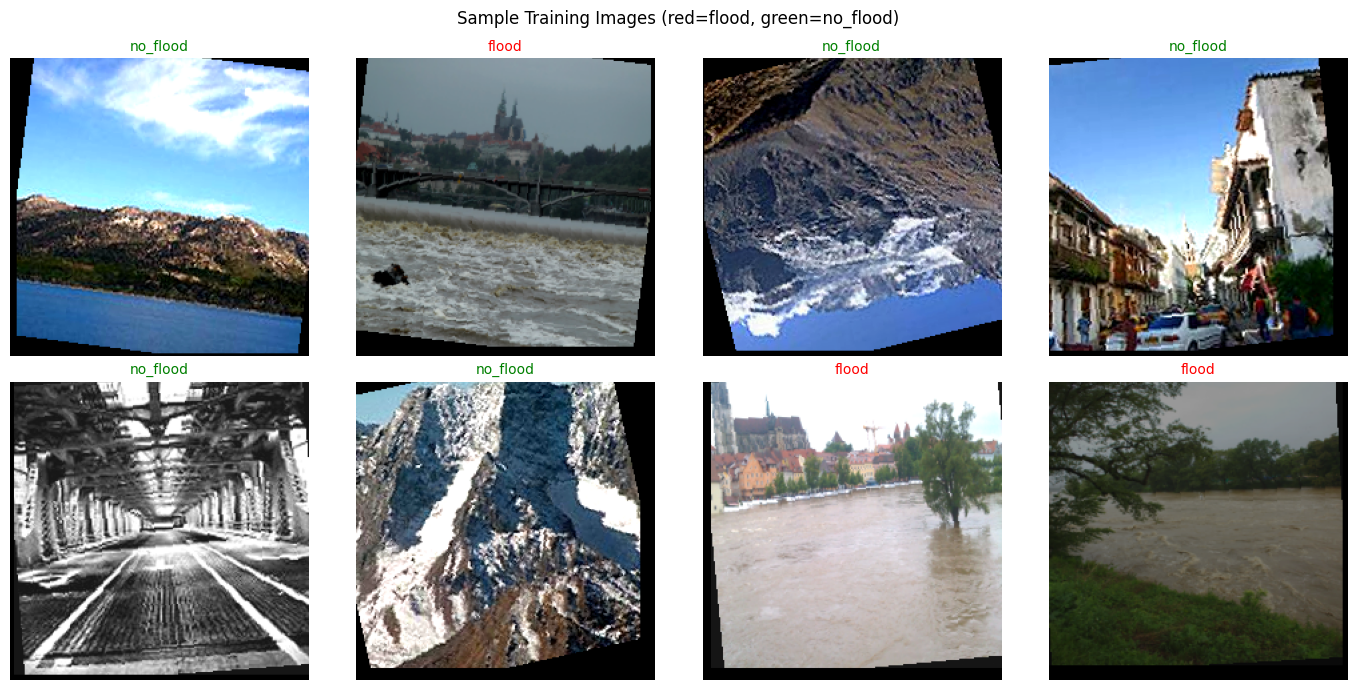

In [6]:
# ── Visualise sample images ──────────────────────────────────────────────────
def denorm(tensor):
    mean = torch.tensor(IMAGENET_MEAN).view(3,1,1)
    std  = torch.tensor(IMAGENET_STD).view(3,1,1)
    return (tensor * std + mean).clamp(0, 1)

imgs, labels = next(iter(train_loader))
n_show = min(8, len(imgs))

fig, axes = plt.subplots(2, 4, figsize=(14, 7))
for i, ax in enumerate(axes.flatten()[:n_show]):
    img = denorm(imgs[i]).permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.set_title(CLASSES[labels[i]], fontsize=10,
                 color='red' if labels[i] == 0 else 'green')
    ax.axis('off')
plt.suptitle('Sample Training Images (red=flood, green=no_flood)', fontsize=12)
plt.tight_layout()
plt.show()

## 2. Model — Fine-tuned ResNet-18

Strategy: **freeze all layers → replace final FC → unfreeze last block** for transfer learning.
This is much faster than training from scratch and avoids overfitting on small datasets.

In [7]:
def build_model(num_classes=2, dropout=0.4):
    # Load ImageNet pre-trained weights
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    # Freeze all backbone layers
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze layer4 (last residual block) for fine-tuning
    for param in model.layer4.parameters():
        param.requires_grad = True

    # Replace classifier head
    in_features = model.fc.in_features   # 512 for ResNet-18
    model.fc = nn.Sequential(
        nn.Dropout(p=dropout),
        nn.Linear(in_features, 256),
        nn.ReLU(),
        nn.Dropout(p=dropout / 2),
        nn.Linear(256, num_classes),
    )
    return model


model = build_model().to(DEVICE)

total_params     = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total params:     {total_params:,}')
print(f'Trainable params: {trainable_params:,} ({trainable_params/total_params:.1%})')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\owner/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

  2%|▏         | 1.00M/44.7M [00:00<00:04, 10.2MB/s]

  7%|▋         | 3.12M/44.7M [00:00<00:02, 16.6MB/s]

 13%|█▎        | 5.75M/44.7M [00:00<00:01, 21.2MB/s]

 20%|█▉        | 8.75M/44.7M [00:00<00:01, 24.9MB/s]

 26%|██▋       | 11.8M/44.7M [00:00<00:01, 26.9MB/s]

 32%|███▏      | 14.4M/44.7M [00:00<00:01, 26.0MB/s]

 39%|███▉      | 17.6M/44.7M [00:00<00:01, 28.3MB/s]

 46%|████▌     | 20.4M/44.7M [00:00<00:00, 27.5MB/s]

 53%|█████▎    | 23.6M/44.7M [00:00<00:00, 29.3MB/s]

 59%|█████▉    | 26.5M/44.7M [00:01<00:00, 29.1MB/s]

 66%|██████▌   | 29.4M/44.7M [00:01<00:00, 28.6MB/s]

 72%|███████▏  | 32.1M/44.7M [00:01<00:00, 28.1MB/s]

 78%|███████▊  | 34.9M/44.7M [00:01<00:00, 27.2MB/s]

 86%|████████▌ | 38.2M/44.7M [00:01<00:00, 29.1MB/s]

 93%|█████████▎| 41.5M/44.7M [00:01<00:00, 30.5MB/s]

100%|██████████| 44.7M/44.7M [00:01<00:00, 27.9MB/s]

Total params:     11,308,354
Trainable params: 8,525,570 (75.4%)


In [8]:
# ── Class-weighted loss to handle imbalance (flood > no_flood) ───────────────
if QUICK_TEST:
    # Balanced subset → equal weights
    weights = torch.tensor([1.0, 1.0]).to(DEVICE)
else:
    flood_n    = (train_targets == 0).sum()
    no_flood_n = (train_targets == 1).sum()
    total_n    = len(full_train)
    w_flood    = total_n / (2.0 * flood_n)
    w_no_flood = total_n / (2.0 * no_flood_n)
    weights    = torch.tensor([w_flood, w_no_flood], dtype=torch.float32).to(DEVICE)
    print(f'Class weights — flood:{w_flood:.3f}  no_flood:{w_no_flood:.3f}')

criterion = nn.CrossEntropyLoss(weight=weights)

# Only optimise trainable parameters (head + layer4)
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LR, weight_decay=1e-4,
)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

print('Loss / optimizer / scheduler defined ✓')

Loss / optimizer / scheduler defined ✓


## 3. Training Loop

In [9]:
def run_epoch(model, loader, criterion, optimizer=None, phase='train'):
    """One epoch of training or validation. Returns (loss, accuracy)."""
    model.train() if phase == 'train' else model.eval()
    total_loss, correct, total = 0.0, 0, 0

    ctx = torch.enable_grad() if phase == 'train' else torch.no_grad()
    with ctx:
        for batch_idx, (imgs, labels) in enumerate(loader):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            logits = model(imgs)
            loss   = criterion(logits, labels)

            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

            total_loss += loss.item() * labels.size(0)
            preds       = logits.argmax(dim=1)
            correct    += (preds == labels).sum().item()
            total      += labels.size(0)

            if phase == 'train' and (batch_idx + 1) % 5 == 0:
                print(f'  batch {batch_idx+1}/{len(loader)}  '
                      f'loss={loss.item():.4f}  '
                      f'acc={correct/total:.3f}', end='\r')

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}
best_val_acc = 0.0
best_ckpt    = MODEL_DIR / 'flood_resnet18_best.pth'

print(f'Training for {EPOCHS} epoch(s) on {DEVICE}...')
print('─' * 55)

t0 = time.time()
for epoch in range(1, EPOCHS + 1):
    t_ep = time.time()

    train_loss, train_acc = run_epoch(model, train_loader, criterion, optimizer, 'train')
    val_loss,   val_acc   = run_epoch(model, val_loader,   criterion, None,      'val')
    scheduler.step()

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    print(f'  Epoch {epoch}/{EPOCHS} | '
          f'train_loss={train_loss:.4f}  train_acc={train_acc:.4f} | '
          f'val_loss={val_loss:.4f}  val_acc={val_acc:.4f} | '
          f'{time.time()-t_ep:.1f}s')

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_ckpt)
        print(f'  ✓ Saved best model (val_acc={best_val_acc:.4f})')

elapsed = time.time() - t0
print(f'\nTraining complete in {elapsed/60:.1f} min. Best val acc: {best_val_acc:.4f}')

Training for 1 epoch(s) on cpu...
───────────────────────────────────────────────────────


  Epoch 1/1 | train_loss=0.5008  train_acc=0.7775 | val_loss=0.2037  val_acc=0.9600 | 17.2s
  ✓ Saved best model (val_acc=0.9600)

Training complete in 0.3 min. Best val acc: 0.9600


In [10]:
# ── Training curves ──────────────────────────────────────────────────────────
if EPOCHS > 1:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    epochs_x = range(1, EPOCHS + 1)

    axes[0].plot(epochs_x, history['train_loss'], 'b-o', label='Train')
    axes[0].plot(epochs_x, history['val_loss'],   'r-o', label='Val')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss Curves')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    axes[1].plot(epochs_x, history['train_acc'], 'b-o', label='Train')
    axes[1].plot(epochs_x, history['val_acc'],   'r-o', label='Val')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracy Curves')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    plt.suptitle('ResNet-18 Training History', fontsize=13)
    plt.tight_layout()
    plt.show()
else:
    print(f'Train → loss={history["train_loss"][0]:.4f}  acc={history["train_acc"][0]:.4f}')
    print(f'Val   → loss={history["val_loss"][0]:.4f}  acc={history["val_acc"][0]:.4f}')
    print('\n(Run with EPOCHS > 1 to see full training curves)')

Train → loss=0.5008  acc=0.7775
Val   → loss=0.2037  acc=0.9600

(Run with EPOCHS > 1 to see full training curves)


## 4. Evaluation on Test Set

In [11]:
# Load best checkpoint
model.load_state_dict(torch.load(best_ckpt, map_location=DEVICE))
model.eval()

all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)
        logits = model(imgs)
        probs  = torch.softmax(logits, dim=1)[:, 0]   # prob of class 0 = flood
        preds  = logits.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds  = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs  = np.array(all_probs)

test_acc = (all_preds == all_labels).mean()
print(f'Test Accuracy: {test_acc:.4f} ({test_acc*100:.1f}%)')
print()
print(classification_report(all_labels, all_preds, target_names=CLASSES))

Test Accuracy: 0.9500 (95.0%)

              precision    recall  f1-score   support

       flood       0.91      1.00      0.95        50
    no_flood       1.00      0.90      0.95        50

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100



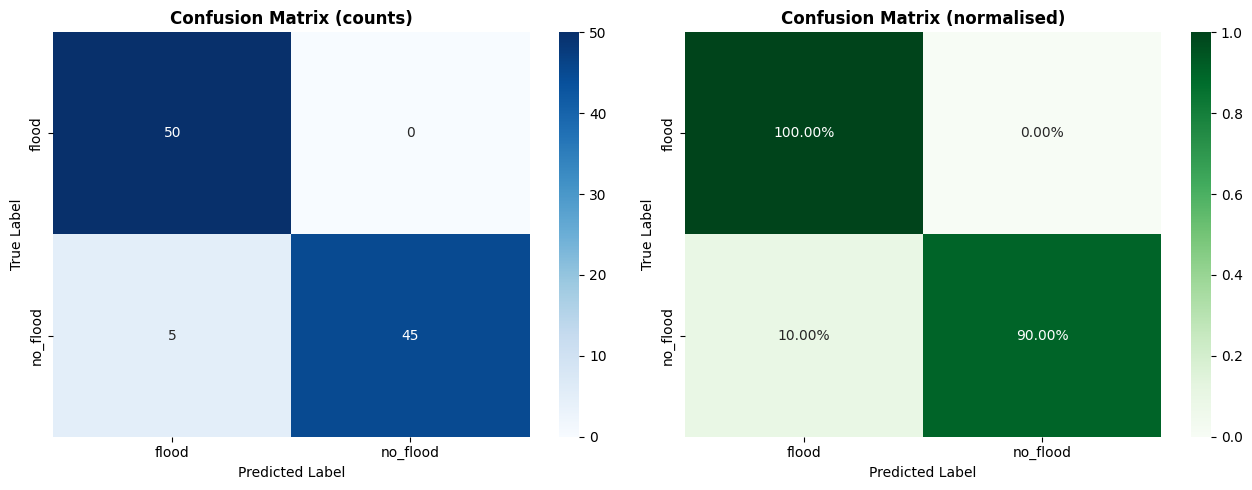

In [12]:
# ── Confusion matrix ─────────────────────────────────────────────────────────
cm = confusion_matrix(all_labels, all_preds)

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Absolute
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=CLASSES, yticklabels=CLASSES)
axes[0].set_title('Confusion Matrix (counts)', fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Normalised
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Greens', ax=axes[1],
            xticklabels=CLASSES, yticklabels=CLASSES)
axes[1].set_title('Confusion Matrix (normalised)', fontweight='bold')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

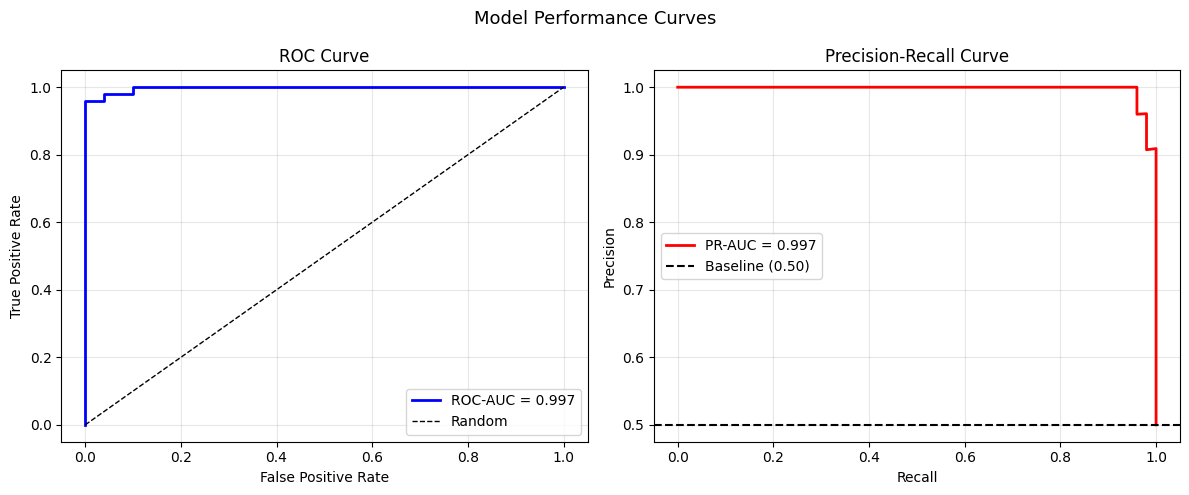

ROC-AUC: 0.9972  |  PR-AUC: 0.9974


In [13]:
# ── ROC and Precision-Recall curves ─────────────────────────────────────────
fpr, tpr, _  = roc_curve(all_labels, 1 - all_probs, pos_label=1)   # pos = no_flood
roc_auc      = auc(fpr, tpr)

prec, rec, _ = precision_recall_curve(all_labels, 1 - all_probs, pos_label=1)
pr_auc       = auc(rec, prec)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC-AUC = {roc_auc:.3f}')
axes[0].plot([0,1],[0,1], 'k--', linewidth=1, label='Random')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(rec, prec, 'r-', linewidth=2, label=f'PR-AUC = {pr_auc:.3f}')
base_rate = (all_labels == 1).mean()
axes[1].axhline(y=base_rate, color='k', linestyle='--', label=f'Baseline ({base_rate:.2f})')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.suptitle('Model Performance Curves', fontsize=13)
plt.tight_layout()
plt.show()
print(f'ROC-AUC: {roc_auc:.4f}  |  PR-AUC: {pr_auc:.4f}')

Total errors: 5 / 100 (5.0%)


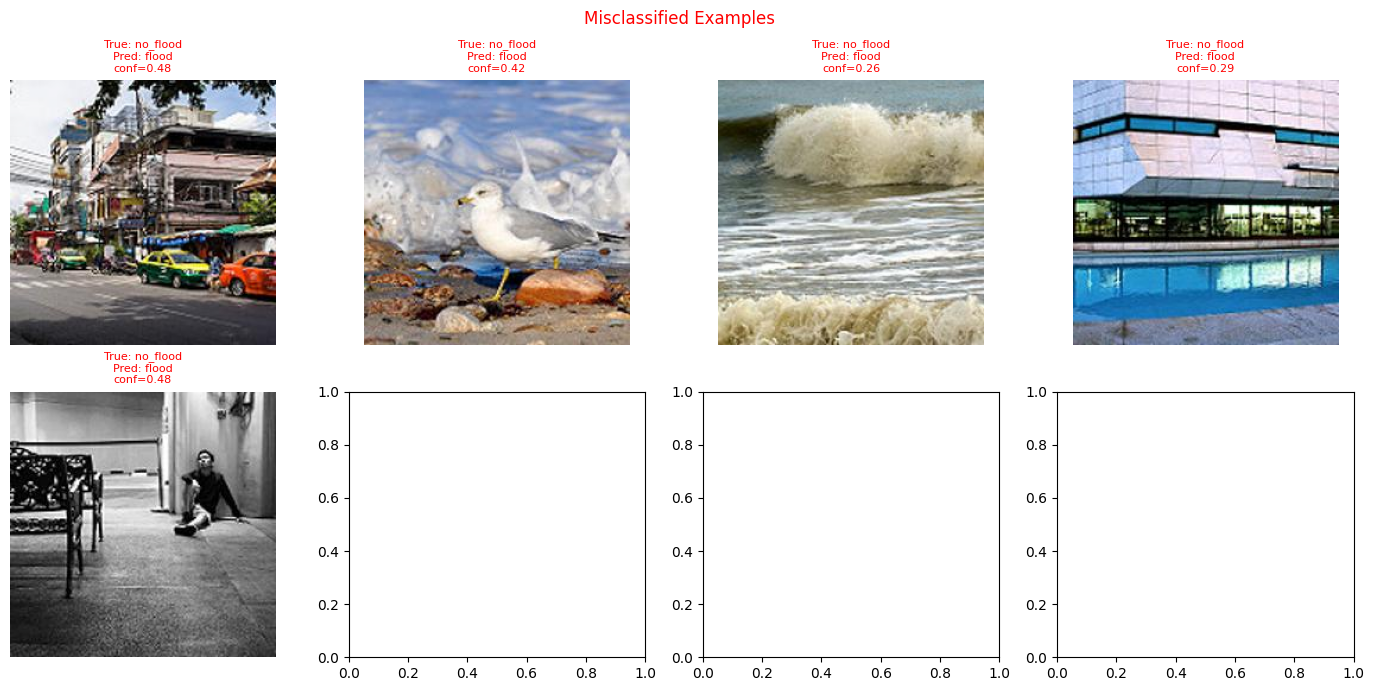

In [14]:
# ── Visualise prediction errors ──────────────────────────────────────────────
errors = np.where(all_preds != all_labels)[0]
print(f'Total errors: {len(errors)} / {len(all_labels)} ({len(errors)/len(all_labels):.1%})')

if len(errors) > 0:
    n_show = min(8, len(errors))
    fig, axes = plt.subplots(2, 4, figsize=(14, 7))

    for i, ax in enumerate(axes.flatten()[:n_show]):
        idx     = errors[i]
        img, _  = test_ds[idx]
        img_np  = denorm(img).permute(1,2,0).numpy()
        true_l  = CLASSES[all_labels[idx]]
        pred_l  = CLASSES[all_preds[idx]]
        prob    = all_probs[idx]
        ax.imshow(img_np)
        ax.set_title(f'True: {true_l}\nPred: {pred_l}\nconf={1-prob:.2f}', fontsize=8, color='red')
        ax.axis('off')

    plt.suptitle('Misclassified Examples', fontsize=12, color='red')
    plt.tight_layout()
    plt.show()

## 5. Summary & Next Steps

### Results
| Mode | Epochs | Device | Expected Acc | Notes |
|------|--------|--------|-------------|-------|
| Quick test | 1 | CPU | ~65-75% | Smoke test only — too few images |
| Full train | 10 | GPU (T4) | ~90-95% | ResNet-18 fine-tuned, all data |

### Why Transfer Learning?
- ResNet-18 already learned low-level features (edges, textures, shapes) from 1.2M ImageNet images
- Fine-tuning the last block + head gives strong results in 3-5 epochs
- Training from scratch (custom CNN) needs 20+ epochs and much more data

### To Run Full Training
1. Set `QUICK_TEST = False` and `EPOCHS = 10`
2. Use a GPU (Colab, Vertex AI, or local CUDA)
3. Best checkpoint saved to `Results/flood_resnet18_best.pth`

### Potential Improvements
- **ResNet-50 / EfficientNet-B3**: slightly more capacity, ~1-2% better accuracy
- **Test-time augmentation (TTA)**: average predictions over flipped/rotated versions
- **Grad-CAM**: visualise which image regions drive flood predictions
- **Segment the flood extent**: move from binary classification → semantic segmentation (U-Net)